# **Gramatical Error Correction**

**Real World/Business Problem**

Writing is a very common means to share ideas and information. Many individuals who are not fluent in english face issues regarding gramatical errors. Writers in english language also face this issue often.

**Problem Statement**

In this CS we are going to perform gramatical error correction. GEC(Grammar Error Correction) is a process of detecting and correcting grammatical errors like spelling, punctuation, grammar, and choice of words.GEC has been treated as a translation problem. Here sentences with mistakes are source language and the correct sentence will be the target sentence. It seems easy but it is a bit complicated because of the large vocabulary and set of rules in grammar. We have to find the error and correct it.

# **Machine Learning Problem**

**Dataset Overview:**

The data in in .m2 file format. Line starting with "S" is incorrect sentance and line starting with "A" is correct sentance.This dataset contains around 1 million data points. We need to convert .m2 file to dataframe with 2 columns one is "Correct" and other is "Incorrect".

Dataset:[Lang-8 dataset](https://docs.google.com/forms/d/17gZZsC_rnaACMXmPiab3kjqBEtRHPMz0UG9Dk-x_F0k/viewform?edit_requested=true)



**Objective**

To correct grammatic errors in the incorrect sentence.

**Train and Test Dataset**

The data is randomly split into train, test set with 90%, 10% of data respectively.

**Evaluation Metric**

GLUE Benchmark will be used as evaluation metric for this CS.

**Usefull Links**

*  https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
*  https://www.scribendi.ai/grammatical-error-correction-with-transformer-models/

* https://towardsdatascience.com/grammar-error-correction-af365dad794
* https://medium.com/@rohansawant7978/grammatical-error-correction-using-deep-learning-ad53044c0977
* https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html



In [ ]:
!pip install textstat

     |████████████████████████████████| 105 kB 5.0 MB/s 
     |████████████████████████████████| 2.0 MB 33.3 MB/s 


In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import seaborn as sns
from collections import Counter
import spacy
import gensim
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
from wordcloud import WordCloud
#from textstat import flesch_reading_ease
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from itertools import chain

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Data Cleaning and Preprocessing**

In [ ]:
#Refer:https://www.cl.cam.ac.uk/research/nl/bea2019st/data/corr_from_m2.py
def preprocess_m2(path,id=0):
    '''This function takes m2 file path as input and converts it to pandas dataframe'''

    m2 = open(path).read().strip().split("\n\n")
    # Do not apply edits with these error types
    skip = {"noop", "UNK", "Um"}

    correct_sent_array = []
    incorrect_sent_array = []

    for sent in tqdm(m2):
        sent = sent.split("\n")
        incor_sent = sent[0].split()[1:] # Ignore "S "
        incorrect_sent_array.append(str(' '.join(incor_sent))) 
        cor_sent = incor_sent.copy()

        edits = sent[1:]
        offset = 0
        for edit in edits:
            edit = edit.split("|||")
            if edit[1] in skip: continue # Ignore certain edits
            coder = int(edit[-1])
            if coder != id: continue # Ignore other coders
            span = edit[0].split()[1:] # Ignore "A "
            start = int(span[0])
            end = int(span[1])
            cor = edit[2].split()
            cor_sent[start+offset:end+offset] = cor
            offset = offset-(end-start)+len(cor)
        correct_sent_array.append(str(' '.join(cor_sent)))

    df = pd.DataFrame()
    df["correct"] = correct_sent_array
    df["incorrect"] = incorrect_sent_array
    return df

In [ ]:
processed_df = preprocess_m2("/content/drive/MyDrive/lang8.train.auto.bea19.m2")

In [ ]:
processed_df.to_csv('lang8.csv')

In [ ]:
!cp lang8.csv /content/drive/MyDrive

In [ ]:
processed_df = pd.read_csv('/content/drive/MyDrive/lang8.csv')
processed_df = processed_df.dropna()

In [ ]:
class Textpreprocessing():

  def remove_space(self,text):
    '''This function removes unwanted spaces'''
    text = re.sub(r" '(\w)",r"'\1",text)
    text = re.sub(r" \,",",",text)
    text = re.sub(r" \.+",".",text)
    text = re.sub(r" \!+"," !",text)
    text = re.sub(r" \?+"," ?",text)
    text = re.sub(" n't","n't",text)
    return text
  
  def expand_words(self, phrase):
    '''This function expands the short form words '''
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

  def remove_unwanted_characters(self,text):
    '''This function removes repeating unwanted characters'''
    text = re.sub("\([^()]*\)","",text) 
    text = re.sub(r"\.+",".",text) 
    text = re.sub(r"\!+","!",text)
    return text

  def preprocessor(self,text):
    '''This function preprocesses the text'''
    text = text.lower()
    
    text = self.remove_space(text)
    text = self.expand_words(text)
    text = self.remove_unwanted_characters(text)
    return text

In [ ]:
correct_sentence = []
incorrect_sentence = []
tp = Textpreprocessing()
for txt in tqdm(processed_df['correct'].values):
  correct_sentence.append(tp.preprocessor(txt))
for txt in tqdm(processed_df['incorrect']):
  incorrect_sentence.append(tp.preprocessor(txt))

100%|██████████| 1037560/1037560 [00:32<00:00, 32349.56it/s]


In [ ]:
clean_df = pd.read_csv('/content/drive/MyDrive/lang8_clean.csv')

In [ ]:
clean_df = clean_df.dropna()
clean_df = clean_df.loc[clean_df["Correct"] != ' ']
clean_df = clean_df.loc[clean_df["Incorrect"] != ' ']
clean_df.head()

,Unnamed: 0,Correct,Incorrect
0,0,good luck on your new start !,good luck on your new start !
1,1,my teacher is going to move to change his job.,my teacher is going to move to change his job.
2,2,he is a so nice guy and taught me english very...,he is a so nice guy and taught me english very...
3,3,and he took in my favorite subjects like soccer.,and he took in my favorite subject like soccer.
4,4,"actually, he was the one who let me know about...","actually, who let me know about lang - 8 was him."


In [ ]:
clean_df.shape

(1034535, 3)

In [ ]:
clean_df[10:15]

,Unnamed: 0,Correct,Incorrect
10,10,good words,good words
11,11,i heard a sentence last night when i was watch...,i heard a sentence last night when i watched tv.
12,12,it reminds and inspires me a lot.,it reminds and inspires me a lot.
13,13,your life is like when you walk.,your life is like when you walk.
14,14,"when you go downhill, you have to stick out yo...","when you go downhill, you have to stick out yo..."


In [ ]:
clean_df_new = clean_df.loc[clean_df["Correct"] != clean_df["Incorrect"]]

In [ ]:
clean_df_new.head()

,Unnamed: 0,Correct,Incorrect
3,3,and he took in my favorite subjects like soccer.,and he took in my favorite subject like soccer.
4,4,"actually, he was the one who let me know about...","actually, who let me know about lang - 8 was him."
6,6,his kanji ability is much better than mine.,his kanji is ability is much better than me.
7,7,"we have known each other for only half a year,...","we have known each other for only half a year,..."
11,11,i heard a sentence last night when i was watch...,i heard a sentence last night when i watched tv.


In [ ]:
clean_df_new = clean_df_new.reset_index()
clean_df_new.head()

,index,Unnamed: 0,Correct,Incorrect
0,3,3,and he took in my favorite subjects like soccer.,and he took in my favorite subject like soccer.
1,4,4,"actually, he was the one who let me know about...","actually, who let me know about lang - 8 was him."
2,6,6,his kanji ability is much better than mine.,his kanji is ability is much better than me.
3,7,7,"we have known each other for only half a year,...","we have known each other for only half a year,..."
4,11,11,i heard a sentence last night when i was watch...,i heard a sentence last night when i watched tv.


In [ ]:
clean_df_new = clean_df_new.drop(['index','Unnamed: 0'], axis = 1)

In [ ]:
clean_df_new.head()

,Correct,Incorrect
0,and he took in my favorite subjects like soccer.,and he took in my favorite subject like soccer.
1,"actually, he was the one who let me know about...","actually, who let me know about lang - 8 was him."
2,his kanji ability is much better than mine.,his kanji is ability is much better than me.
3,"we have known each other for only half a year,...","we have known each other for only half a year,..."
4,i heard a sentence last night when i was watch...,i heard a sentence last night when i watched tv.


In [ ]:
clean_df_new.to_csv('clean_df.csv')

In [ ]:
!cp clean_df.csv /content/drive/MyDrive

# **Exploratory Data Analysis**

In [ ]:
#Code reference : https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
class EDA():
  def wordcloud(self,clean_df):
    '''This function generates wordcloud '''
    correct_text_corpus =''
    for txt in clean_df['Correct']:
        txt = txt.lower()
        correct_text_corpus += txt

    incorrect_text_corpus =''
    for txt in clean_df['Incorrect']:
        txt = txt.lower()
        incorrect_text_corpus += txt

    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations = False,
                min_font_size = 10,max_words=200).generate(correct_text_corpus)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title("WordCloud of Correct Sentences")
    plt.show()

    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',collocations = False,
                min_font_size = 10,max_words=200).generate(incorrect_text_corpus)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title("WordCloud of Inorrect Sentences")
    plt.show()

  def pos_countplot(self,text):
    '''This function generates countplot for parts of speech'''
    tags = []
    for txt in tqdm(text):
      pos_tag=nltk.pos_tag(word_tokenize(txt))
      pos_tag=list(list(zip(*pos_tag))[1])
      tags.extend(pos_tag)
    counter=Counter(tags)

    x,y=list(map(list,zip(*counter.most_common(10))))
      
    sns.barplot(x=y,y=x)

  def flesch_reading_ease_eda(self,text):
    '''This function plots histogram of FRE'''
    flesch_reading_ease_list = []
    for txt in tqdm(text):
      flesch_reading_ease_list.append(flesch_reading_ease(txt))
    flesch_reading_ease_list = list(filter(lambda x : x > 0, flesch_reading_ease_list))
    plt.hist(flesch_reading_ease_list)

  def ngram_eda(self,text,n):
    '''TThis function plots barplot of count of n-grams'''
    list_of_sentences = list(text.str.split().values)
    corpus = list(chain.from_iterable(list_of_sentences))
    def top_ngram(corpus, n=None):
          vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
          bag_of_words = vec.transform(corpus)
          sum_words = bag_of_words.sum(axis=0) 
          words_freq = [(word, sum_words[0, idx]) 
                        for word, idx in vec.vocabulary_.items()]
          words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
          return words_freq[:10]

    top_n_bigrams=top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

  def word_count(self,text):#need to change to corpus
    '''This function retuns an array of word count in each document'''
    sent_len = []
    for sent in text:
      sent_len.append(len(sent.split()))
    return np.array(sent_len)


In [ ]:
eda = EDA()

# **WordCloud**

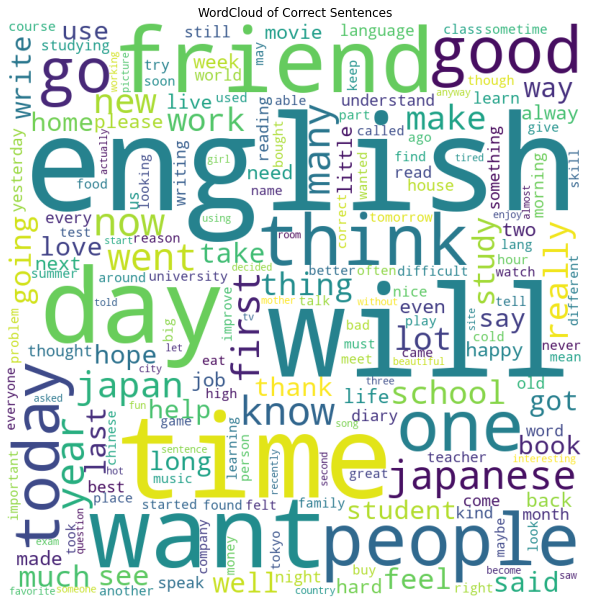

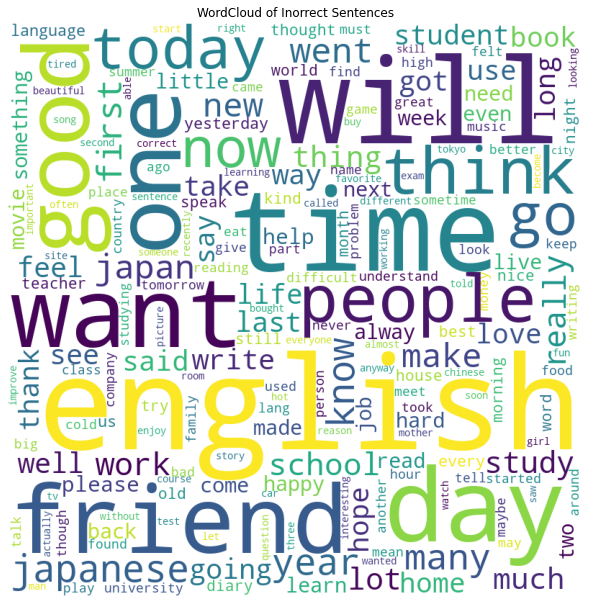

In [ ]:

eda.wordcloud(clean_df)

**Observation:**
From the wordcloud of Correct and Incorrect sentences 


*   English
*   Day
*   Time
*   Will
*   People
*   Want

These are the most common words.



# **Parts of speech Count Plot**

100%|██████████| 1034535/1034535 [14:08<00:00, 1219.48it/s]


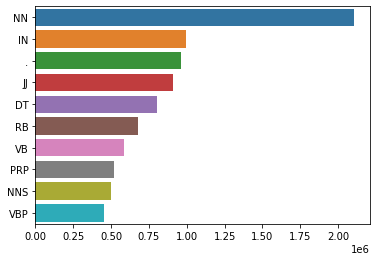

In [ ]:
eda.pos_countplot(clean_df["Correct"])

100%|██████████| 1034535/1034535 [13:19<00:00, 1294.19it/s]


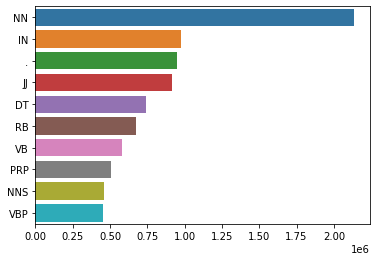

In [ ]:
eda.pos_countplot(clean_df["Incorrect"])

**Observation:**

*  The above plot shows the frequency of parts of speech in the dataset.
*  Both the correct and Incorrect data has similar distribution of parts of speech, but there is a slight decrease in number of NNS(Noun plural).
*  Maximum occuring part of speech is NN(Noun singular) followed by IN(preposition).

# **N-Gram plot**

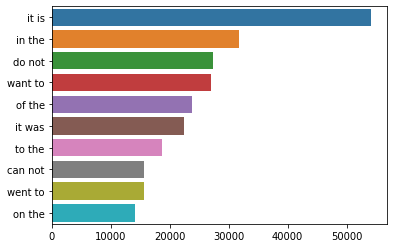

In [ ]:
eda.ngram_eda(clean_df["Correct"],2)

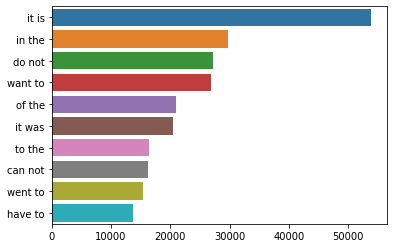

In [ ]:
eda.ngram_eda(clean_df["Incorrect"],2)

**Observation:**

*  The above plot shows maximum occuring bi-grams in the dataset.
*  The most frequent bi-gram is "it is".
*  9 out of 10 bi-grams are same in both correct and incorrect sentences but the count is different.
*  "on the" and "have to" are the unique bi-grams which do not repeat in both correct and incorrect dataset.


# **Flesch Reading Ease Plot**

100%|██████████| 1034535/1034535 [00:38<00:00, 26856.15it/s]


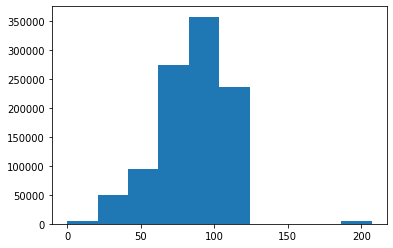

In [ ]:
eda.flesch_reading_ease_eda(clean_df["Correct"])

100%|██████████| 1034535/1034535 [00:37<00:00, 27581.80it/s]


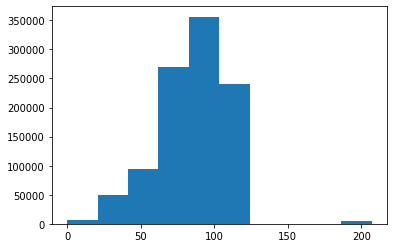

In [ ]:
eda.flesch_reading_ease_eda(clean_df["Incorrect"])

**FRE Scale:**
* 0-30 College
* 50-60 High school
* 60+ Fourth grade
**Observation:**

* Distribution of readability of correct and incorrect sentences is same.
* Most of the the sentences have 60+ score(Forth grade level).
* less sentences have 0-30 score(College Level)

# **Join Plot on word count**

In [ ]:
wc_correct_sentence = eda.word_count(clean_df["Correct"])

In [ ]:
wc_incorrect_sentence = eda.word_count(clean_df["Incorrect"])

In [ ]:
wcdf = pd.DataFrame(list(zip(wc_correct_sentence, wc_incorrect_sentence)),columns =['Correct', 'Incorrect'])

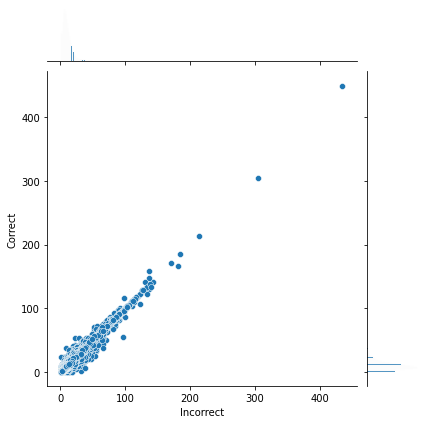

In [ ]:
sns.jointplot(x ='Incorrect', y ='Correct', data = wcdf,kind = "scatter")

**Observation:**


*   For sentences with <100 words mostly the word count of correct sentences and incorrect sentences is not equal some have more words in correct sentence others have more words in incorrect sentence.
*   When the length of sentences increases the difference between the word count of correct sentences and incorrect sentences reduces

